# Classificació

### Libraries and loading data

In [1]:
import pandas as pd
from sklearn.svm import SVC
from skopt import BayesSearchCV
import numpy as np
np.int = int

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from sklearn.metrics import  ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings("ignore")

In [81]:
df_train = pd.read_csv('../datasets/data_train_class7.csv')
df_test = pd.read_csv('../datasets/data_test_class7.csv')

In [108]:
# df_train = df_train.iloc[:, :-7]
# df_test = df_test.iloc[:, :-7]

In [83]:
df_train.head()

,BPM,Energy,Danceability,Loudness,Liveness,Valence,Length,Acousticness,Speechiness,Popularity,is_recent
0,123,73,48,-8,11,87,140,57,17,65,1
1,99,21,34,-17,18,29,218,40,3,70,0
2,71,58,39,-7,22,38,295,47,3,63,0
3,135,23,40,-9,11,28,222,89,4,61,1
4,159,16,41,-22,12,42,199,88,3,77,0


In [84]:
x_train = df_train.drop(columns=['is_recent', 'Length'])
y_train = df_train['is_recent']

x_test = df_test.drop(columns=['is_recent', 'Length'])
y_test = df_test['is_recent']

clss = ['Pre-2000', 'Post-2000']

In [85]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1395.0,0.456174,0.179555,0.0,0.318471,0.452229,0.557325,1.0
1,1395.0,0.583587,0.229908,0.0,0.401042,0.604167,0.770833,1.0
2,1395.0,0.500500,0.179877,0.0,0.383721,0.500000,0.627907,1.0
3,1395.0,0.723097,0.145117,0.0,0.640000,0.760000,0.840000,1.0
4,1395.0,0.175110,0.169782,0.0,0.072165,0.103093,0.216495,1.0
5,1395.0,0.480615,0.258486,0.0,0.270833,0.458333,0.677083,1.0
6,1395.0,0.131427,0.070653,0.0,0.093407,0.118524,0.152276,1.0
7,1395.0,0.298786,0.296839,0.0,0.030612,0.183673,0.520408,1.0
8,1395.0,0.057672,0.082810,0.0,0.018868,0.037736,0.056604,1.0
9,1395.0,0.542193,0.162211,0.0,0.426966,0.561798,0.674157,1.0


## Models

In [86]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score


def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'test f1 score (0)'] = f1_score(y_test, clf.predict(X_test), pos_label=0)
    df.loc[nclf,'test f1 score (1)'] = f1_score(y_test, clf.predict(X_test), pos_label=1)
    df.loc[nclf,'test f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    # df.loc[nclf,'ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    return df

results_df = pd.DataFrame()

In [87]:
niter = 15
cv = 10

### Naive-Bayes

In [88]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


In [89]:
gnb_model = GaussianNB().fit(x_train, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=x_train.columns
means

Priors: [0.59928315 0.40071685]
Means:



,0,1,2,3,4,5,6,7,8,9
0,0.452024,0.564132,0.497079,0.682775,0.170300,0.51008,0.136212,0.317120,0.052022,0.555615
1,0.462382,0.612683,0.505616,0.783399,0.182303,0.43655,0.124272,0.271367,0.066122,0.522120


In [90]:
print(classification_report(gnb_model.predict(x_test), y_test,target_names=clss))
results_df = save_results(gnb_model, x_test, y_test, 'GNB', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.76      0.73      0.74       375
   Post-2000       0.57      0.62      0.59       224

    accuracy                           0.69       599
   macro avg       0.67      0.67      0.67       599
weighted avg       0.69      0.69      0.69       599



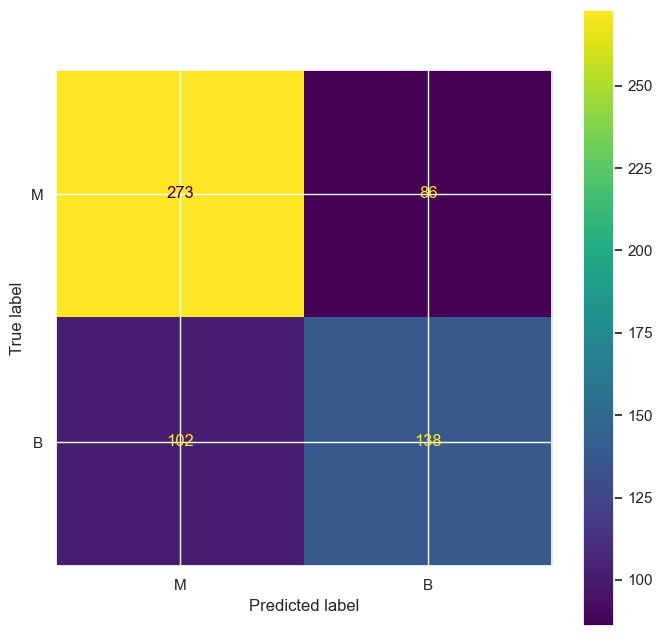

In [91]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, x_test,y_test, display_labels=['M', 'B'], ax=plt.subplot());

### QDA

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [92]:
qda = QuadraticDiscriminantAnalysis()
param = {'reg_param':np.linspace(0,1,21, endpoint=True)}
qda_gs =  GridSearchCV(qda,param,cv=cv, n_jobs=-1, scoring='f1_weighted', refit=True).fit(x_train, y_train);

In [93]:
show_html(pd.DataFrame(qda_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
0,{'reg_param': 0.0},0.736601,1
1,{'reg_param': 0.05},0.572521,2
2,{'reg_param': 0.1},0.470508,3
3,{'reg_param': 0.15000000000000002},0.450370,4
4,{'reg_param': 0.2},0.449126,5


In [94]:
print(classification_report(qda_gs.predict(x_test), y_test,target_names=clss))
results_df = save_results(qda_gs, x_test, y_test, 'QDA', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.79      0.74      0.76       379
   Post-2000       0.60      0.65      0.62       220

    accuracy                           0.71       599
   macro avg       0.69      0.70      0.69       599
weighted avg       0.72      0.71      0.71       599



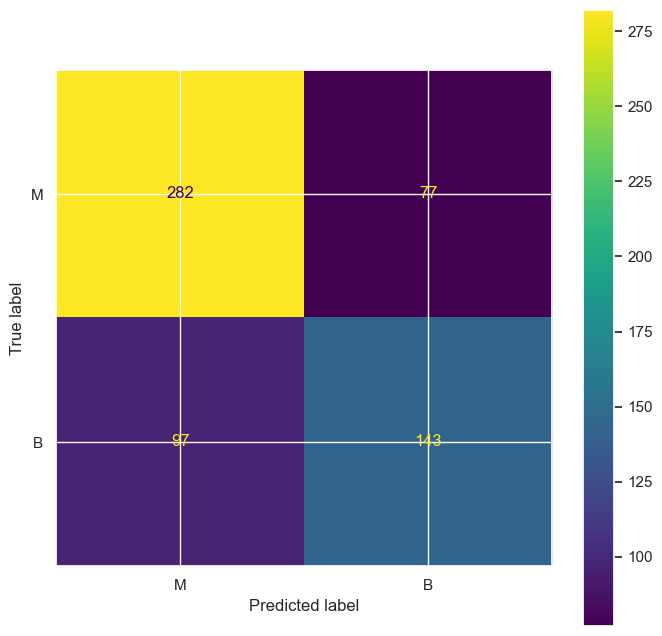

In [95]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(qda_gs, x_test,y_test, display_labels=['M', 'B'], ax=plt.subplot());

### SVM lineal

In [96]:
from sklearn.model_selection import cross_val_score


param = {'C': 10**np.linspace(-3, 3, 101)}

lsvm = BayesSearchCV(SVC(kernel='linear', random_state=0), 
                     param, 
                     n_iter=niter,
                     cv=cv,
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0, scoring='f1_weighted').fit(x_train, y_train)
# y_test_predicted_lsvm = lsvm.predict(x_test)

# r2_lsvm_train = np.mean(cross_val_score(lsvm, x_train, y_train))
# r2_lsvm_test = np.mean(cross_val_score(lsvm, x_test, y_test))

# print(f'Train R2 score: {r2_lsvm_train}')
# print(f'Test R2 score: {r2_lsvm_test}')

In [98]:
show_html(pd.DataFrame(lsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
6,{'C': 660.6934480075951},0.728195,1
5,{'C': 109.64781961431851},0.727344,2
12,{'C': 54.954087385762485},0.726514,3
13,{'C': 72.44359600749891},0.726514,3
14,{'C': 15.848931924611142},0.725059,5


In [99]:
print(classification_report(lsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(lsvm, x_test, y_test, 'SVM Lineal', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.81      0.74      0.77       394
   Post-2000       0.57      0.66      0.61       205

    accuracy                           0.71       599
   macro avg       0.69      0.70      0.69       599
weighted avg       0.73      0.71      0.72       599



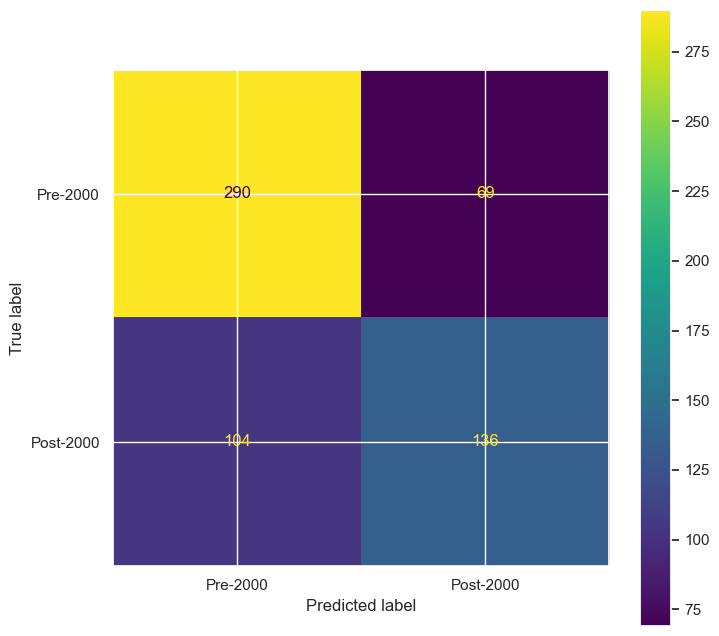

In [100]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### SVM Polinomial

In [101]:
param = {'C': 10**np.linspace(-3, 3, 101),
         'degree':[2,3]}

qsvm = BayesSearchCV(SVC(kernel='poly', random_state=0), 
                     param, 
                     n_iter=niter,
                     cv=cv, 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0, scoring='f1_weighted').fit(x_train, y_train)
# y_test_predicted_qsvm = qsvm.predict(x_test)
# r2_qsvm_train = np.mean(cross_val_score(qsvm, x_train, y_train))
# r2_qsvm_test = np.mean(cross_val_score(qsvm, x_test, y_test))

# print(f'Train R2 score: {r2_qsvm_train}')
# print(f'Test R2 score: {r2_qsvm_test}')

In [103]:
show_html(pd.DataFrame(qsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,"{'C': 2.2908676527677723, 'degree': 2}",0.751921,1
2,"{'C': 1.513561248436207, 'degree': 2}",0.750782,2
12,"{'C': 6.025595860743575, 'degree': 2}",0.747748,3
7,"{'C': 1.1481536214968828, 'degree': 3}",0.740358,4
13,"{'C': 0.43651583224016566, 'degree': 2}",0.740010,5


In [104]:
print(classification_report(qsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(qsvm, x_test, y_test, 'SVM Polinomic', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.82      0.75      0.79       390
   Post-2000       0.60      0.69      0.64       209

    accuracy                           0.73       599
   macro avg       0.71      0.72      0.71       599
weighted avg       0.74      0.73      0.73       599



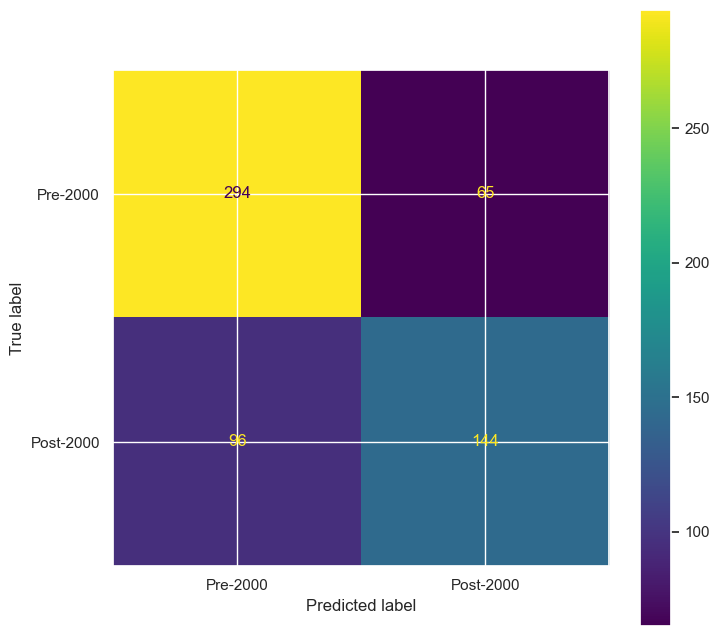

In [105]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(qsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### SVM RBF

In [106]:
param = {'C':10**np.linspace(-3,3,101), 
         'gamma':['scale','auto']}

rbfsvm = BayesSearchCV(SVC(kernel='rbf', random_state=0), 
                     param, 
                     n_iter=niter, 
                     cv=cv,
                     scoring='f1_weighted',
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
# y_test_predicted_rbfsvm = rbfsvm.predict(x_test)
# r2_rbfsvm_train = np.mean(cross_val_score(rbfsvm, x_train, y_train))
# r2_rbfsvm_test = np.mean(cross_val_score(rbfsvm, x_test, y_test))

# print(f'Train R2 score: {r2_rbfsvm_train}')
# print(f'Test R2 score: {r2_rbfsvm_test}')

In [27]:
show_html(pd.DataFrame(rbfsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'C': 125.89254117941661, 'gamma': 'auto'}",0.767354,1
10,"{'C': 331.13112148259074, 'gamma': 'auto'}",0.766250,2
12,"{'C': 6.918309709189363, 'gamma': 'scale'}",0.763992,3
0,"{'C': 1.513561248436207, 'gamma': 'scale'}",0.742618,4
7,"{'C': 1.1481536214968828, 'gamma': 'scale'}",0.737811,5


In [28]:
print(classification_report(rbfsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(rbfsvm, x_test, y_test, 'SVM RBF', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.77      0.81       391
   Post-2000       0.63      0.73      0.68       208

    accuracy                           0.76       599
   macro avg       0.74      0.75      0.74       599
weighted avg       0.77      0.76      0.76       599



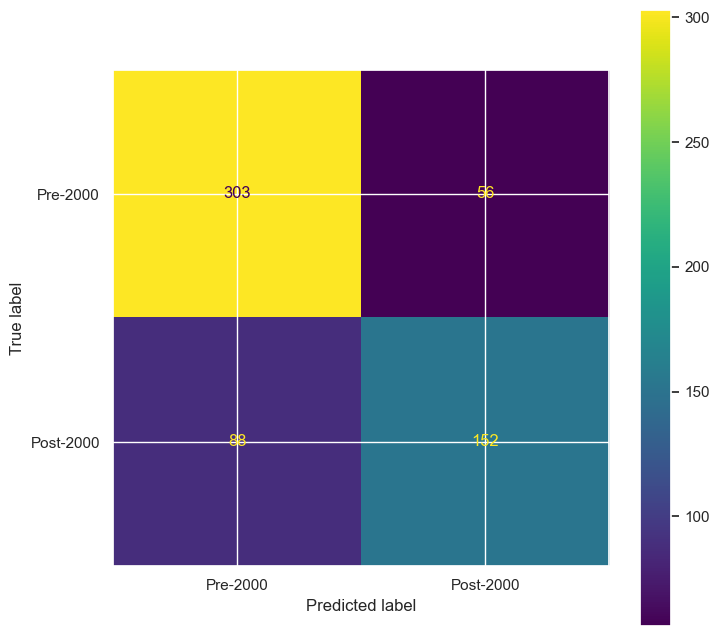

In [29]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbfsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier


param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn = BayesSearchCV(KNeighborsClassifier(), 
                     param, 
                     n_iter=niter,
                     cv=cv,
                     scoring='f1_weighted', 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
# y_test_predicted_knn = knn.predict(x_test)
# r2_knn_train = np.mean(cross_val_score(knn, x_train, y_train))
# r2_knn_test = np.mean(cross_val_score(knn, x_test, y_test))

# print(f'Train R2 score: {r2_knn_train}')
# print(f'Test R2 score: {r2_knn_test}')

In [32]:
show_html(pd.DataFrame(knn.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.726731,1
0,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'uniform'}",0.726246,2
10,"{'leaf_size': 1, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'uniform'}",0.726246,2
7,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 11, 'weights': 'distance'}",0.718735,4
13,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.718143,5


In [33]:
print(classification_report(knn.predict(x_test), y_test, target_names=clss))
results_df = save_results(knn, x_test, y_test, 'KNN', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.81      0.73      0.77       400
   Post-2000       0.55      0.66      0.60       199

    accuracy                           0.70       599
   macro avg       0.68      0.69      0.68       599
weighted avg       0.72      0.70      0.71       599



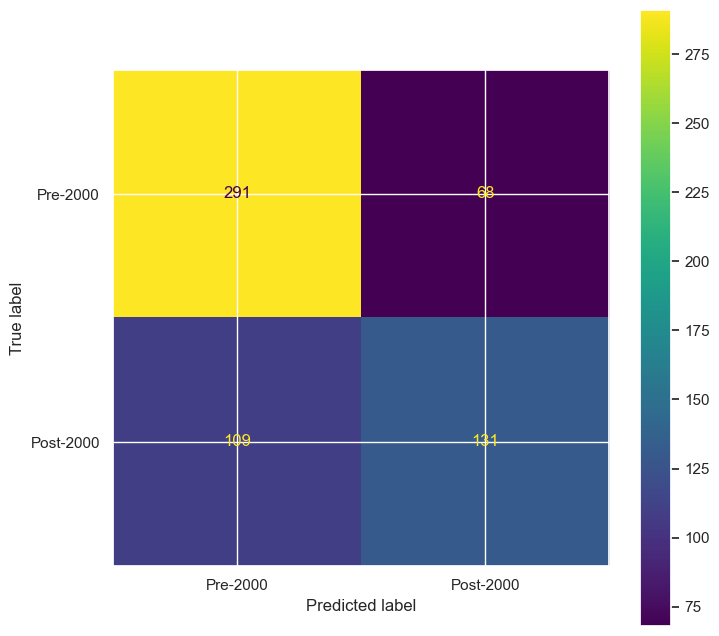

In [34]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier


param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rforest = BayesSearchCV(RandomForestClassifier(), 
                        param, n_iter=niter, cv=cv, scoring='f1_weighted', n_jobs=-1, refit=True, random_state=0).fit(x_train, y_train)
# y_test_predicted_rforest = rforest.predict(x_test)
# r2_rforest_train = np.mean(cross_val_score(rforest, x_train, y_train))
# r2_rforest_test = np.mean(cross_val_score(rforest, x_test, y_test))

# print(f'Train R2 score: {r2_rforest_train}')
# print(f'Test R2 score: {r2_rforest_test}')

In [37]:
show_html(pd.DataFrame(rforest.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
0,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75}",0.766068,1
14,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 75}",0.763893,2
8,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}",0.760095,3
13,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 25}",0.759814,4
1,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 50}",0.757620,5


In [38]:
print(classification_report(rforest.predict(x_test), y_test, target_names=clss))
results_df = save_results(rforest, x_test, y_test, 'Random Forest', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.87      0.75      0.81       414
   Post-2000       0.57      0.75      0.65       185

    accuracy                           0.75       599
   macro avg       0.72      0.75      0.73       599
weighted avg       0.78      0.75      0.76       599



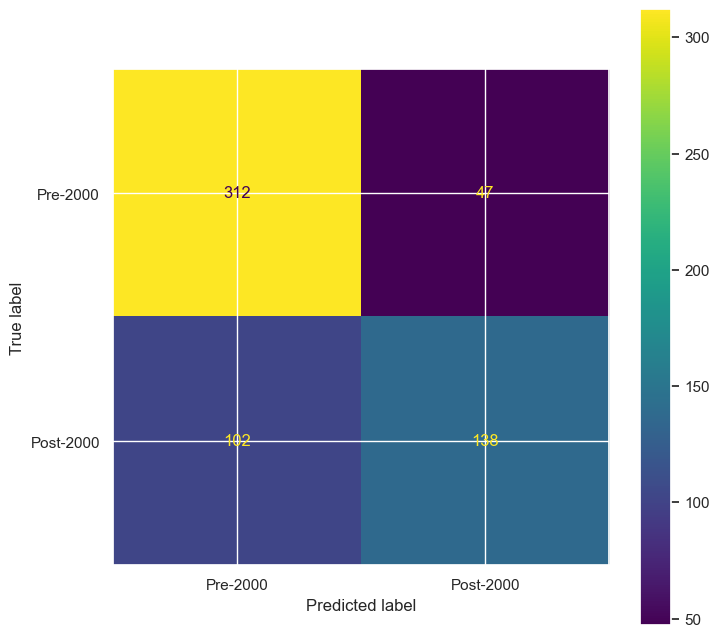

In [39]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rforest, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingClassifier


param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss', 'exponential'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gboost = BayesSearchCV(GradientBoostingClassifier(random_state=0, n_iter_no_change=5), 
                        param, 
                        n_iter=15,
                        cv=cv, 
                        n_jobs=-1, 
                        refit=True, 
                        random_state=0, scoring='f1_weighted').fit(x_train, y_train)

In [41]:
show_html(pd.DataFrame(gboost.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
4,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.757650,1
11,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 75}",0.757080,2
14,"{'criterion': 'friedman_mse', 'learning_rate': 1.0, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 75}",0.739337,3
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.730508,4
12,"{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.730508,4


In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
#          'loss':['log_loss', 'exponential'], 
#          'criterion':['friedman_mse', 'squared_error'], 
#          'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
#          'min_samples_leaf':[1,2,3,5,10], 
#          'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

# gboost = BayesSearchCV(GradientBoostingClassifier(random_state=0, n_iter_no_change=5), 
#                         param, 
#                         n_iter=niter, 
#                         n_jobs=-1, 
#                         refit=True, 
#                         random_state=0).fit(x_train, y_train)
# y_test_predicted_gboost = gboost.predict(x_test)
# r2_gboost_train = np.mean(cross_val_score(gboost, x_train, y_train))
# r2_gboost_test = np.mean(cross_val_score(gboost, x_test, y_test))

# print(f'Train R2 score: {r2_gboost_train}')
# print(f'Test R2 score: {r2_gboost_test}')

In [42]:
print(classification_report(gboost.predict(x_test), y_test, target_names=clss))
results_df = save_results(gboost, x_test, y_test, 'Gradient Boosting', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.74      0.78       409
   Post-2000       0.55      0.69      0.61       190

    accuracy                           0.72       599
   macro avg       0.69      0.72      0.70       599
weighted avg       0.75      0.72      0.73       599



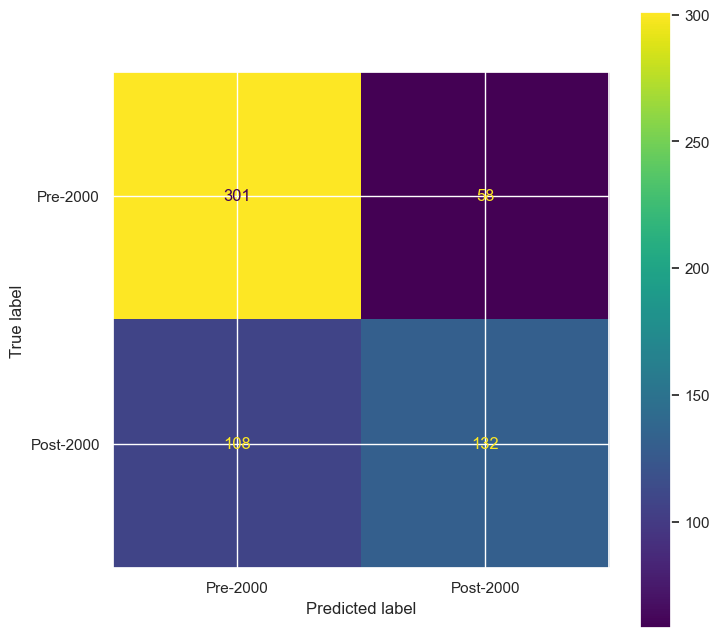

In [43]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gboost, x_test, y_test, display_labels=clss, ax=plt.subplot());

### MLP

In [44]:
from sklearn.neural_network import MLPClassifier

In [45]:
param = {'hidden_layer_sizes':[10, 50, 100, 200], 
         'activation':['relu', 'logistic', 'identity'], 
         'learning_rate_init': [0.001, 0.01, 0.1]  }

mlp =  BayesSearchCV(MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=20,learning_rate='adaptive',random_state=0), 
                     param, cv=cv, n_jobs=-1, refit=True, scoring='f1_weighted').fit(x_train, y_train)

In [46]:
show_html(pd.DataFrame(mlp.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
15,"{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.756882,1
29,"{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.756882,1
28,"{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.756882,1
31,"{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.756882,1
48,"{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.756882,1


In [47]:
print(classification_report(mlp.predict(x_test), y_test, target_names=clss))
results_df = save_results(mlp, x_test, y_test, 'MLP', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.80      0.80      0.80       359
   Post-2000       0.70      0.70      0.70       240

    accuracy                           0.76       599
   macro avg       0.75      0.75      0.75       599
weighted avg       0.76      0.76      0.76       599



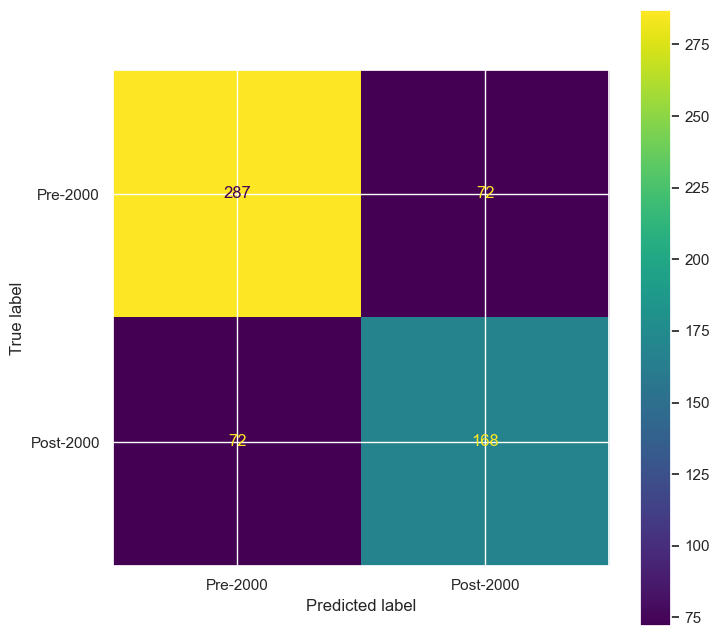

In [48]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp, x_test, y_test, display_labels=clss, ax=plt.subplot());

## Conclusions

In [64]:
results_sorted = results_df.sort_values(by=['test f1 score (W)'], ascending=False)
results_sorted

,train XV acc,test acc,test f1 score (0),test f1 score (1),test f1 score (W)
MLP,0.756882,0.759599,0.799443,0.700000,0.749721
SVM Polinomic,0.768006,0.762938,0.811671,0.680180,0.745926
SVM RBF,0.767354,0.759599,0.808000,0.678571,0.743286
SVM Lineal,0.747882,0.746244,0.794595,0.668122,0.731358
Random Forest,0.766068,0.751252,0.807245,0.649412,0.728328
Gradient Boosting,0.757650,0.722871,0.783854,0.613953,0.698904
GNB,NaN,0.694491,0.726457,0.654064,0.690261
QDA,0.718284,0.686144,0.702532,0.667845,0.685188
KNN,0.726731,0.704508,0.766798,0.596811,0.681805


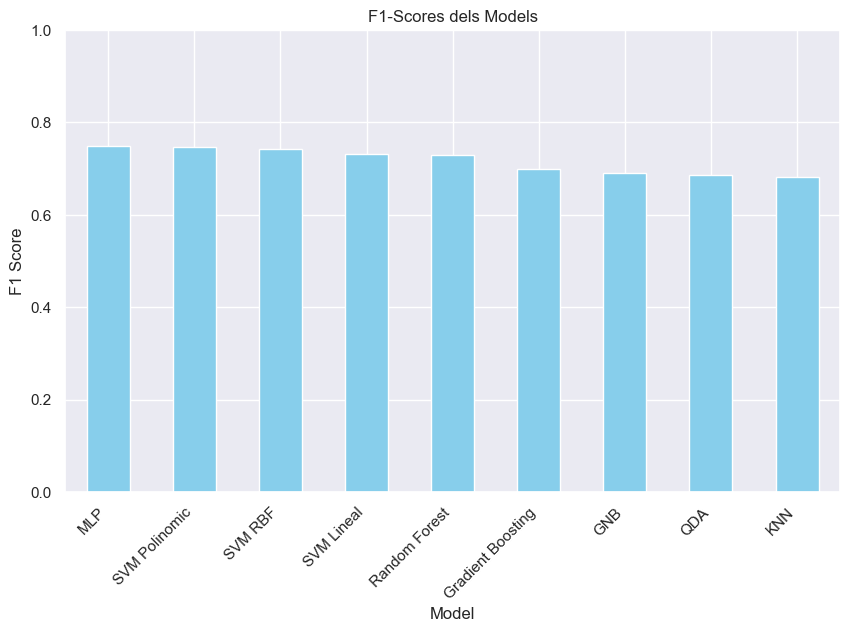

In [65]:
plt.figure(figsize=(10, 6))
results_sorted['test f1 score (W)'].plot(kind='bar', color='skyblue')
plt.title('F1-Scores dels Models')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.show()

## Neural network tensorFlow

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


2024-01-04 11:31:00.674500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [74]:

# Define the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryF1Score()])

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

# Make predictions on the test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = f1_score(y_test, y_pred)
print(f'Test f1-score: {accuracy:.4f}')

AttributeError: module 'keras.api._v2.keras.metrics' has no attribute 'BinaryF1Score'